In [18]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
pd.options.mode.chained_assignment = None
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from pmdarima import auto_arima
import warnings 
warnings.filterwarnings("ignore") 

def check_for_nulls(df, columns):
    '''
    Checks for null values inside of a dataset and will tell you how many nulls
    are in each column.

    ARGS:
        df - dataframe
        columns - column labels
    RETURN:
        Dictionary with columns listed that have null values if there are any.
    '''

    true_values = {}
    for col in columns:
        true_values[col] = df[col].isnull().sum()
    return true_values

def drop_columns(df, columns, num_df):
    '''
    Goes through the dataframe and drops specified columns 

    ARGS:
        df - dataframe
        columns - column labels
    '''
    pass

def replace_col_values(df, columns, repl_val, replace):
    '''
    Goes through dataframe column and replaces with specified word

    ARGS:
        df- dataframe
        columns - column labels
        repl_val - value you want to replace
        replace - string value

    RETURN:
        Dataframe with values in columns replaced with replacement string
    '''
    df[columns] = df[columns].replace([repl_val], replace)
    return df

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

city_temp = pd.read_csv('../data/city_temperature.csv', low_memory = False)
city_temp = city_temp.drop(['State'], axis = 1)
city_temp = city_temp.loc[city_temp['AvgTemperature'] > -90]



global_temp = city_temp.drop(['Region', 'Country', 'City', 
             ], axis = 1).groupby(['Year','Month', 'Day']).mean().reset_index()
global_temp = global_temp.loc[(global_temp['Year'] < 2017) & (global_temp['AvgTemperature'] > -90)]
global_temp_year = global_temp.drop(['Month', 'Day'], axis = 1).groupby('Year').mean()

# global_temp['Date'] = pd.to_datetime(global_temp[['Year', 'Month', 'Day']])
# global_temp = global_temp.drop(['Year', 'Month', 'Day'], axis=1)
global_temp

,Year,Month,Day,AvgTemperature
0,1995,1,1,44.115101
1,1995,1,2,41.783388
2,1995,1,3,39.199342
3,1995,1,4,37.294444
4,1995,1,5,35.762623
...,...,...,...,...
8026,2016,12,27,50.885911
8027,2016,12,28,49.985616
8028,2016,12,29,48.963823
8029,2016,12,30,46.716382


In [19]:

global_temp = global_temp.groupby(['Year', 'Month']).mean('AvgTemperature').reset_index()
# global_temp = global_temp.drop('Day', axis = 1)
global_temp['Date'] = pd.to_datetime(global_temp[['Year', 'Month']].assign(day=1))
global_temp.index = global_temp.Date
global_temp = global_temp.drop(['Year', 'Month', 'Date'], axis=1)
global_temp

,Day,AvgTemperature
Date,,
1995-01-01,16.0,44.268942
1995-02-01,14.5,46.449219
1995-03-01,16.0,52.278501
1995-04-01,15.5,58.006700
1995-05-01,16.0,65.414693
...,...,...
2016-08-01,16.0,75.879421
2016-09-01,15.5,71.612916
2016-10-01,16.0,63.601780


In [20]:

from statsmodels.tsa.seasonal import seasonal_decompose
# series = ...
# result = seasonal_decompose(global_temp, model='additive')
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
# global_temp.index = global_temp.Date
# global_temp = global_temp.drop(['index', 'Year', 'Month', 'Day', 'Date'], axis = 1)

result = seasonal_decompose(global_temp['AvgTemperature'], model='additive')

def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

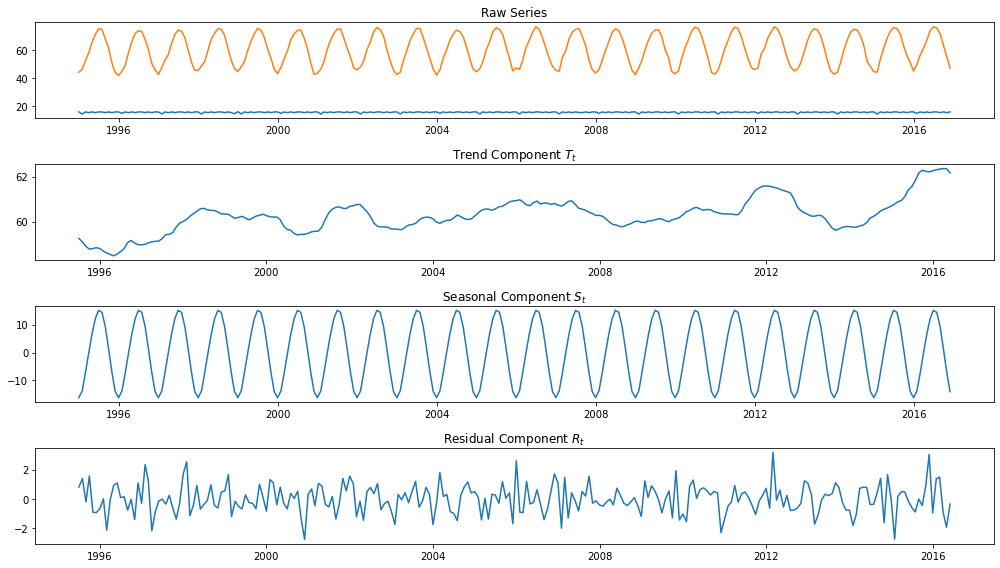

In [21]:

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, global_temp, result)
plt.tight_layout()

In [22]:


city_highest = city_temp.drop(['Region','Month','Day'], axis = 1)
city_highest = city_highest.groupby(['Country', 'City', 'Year']).mean('AvgTemperature').reset_index()
city_highest = city_highest.loc[(city_highest['Year'] == 2000) | (city_highest['Year'] == 2015)]
city_highest = city_highest.groupby(['Country', 'City', 'Year']).mean('AvgTemperature').reset_index()

pivot_data = pd.pivot_table(city_highest, values='AvgTemperature', index=['City', 'Country'], columns = 'Year')
pivot_data = pivot_data.loc[pivot_data[2000] > -50]
pivot_data['Diff'] = pivot_data[2015] - pivot_data[2000]
pivot_data_10 = pivot_data.nlargest(10, 'Diff')

drop_off = pivot_data_10.drop('Diff', axis = 1)
drop_off = drop_off.reset_index()
drop_off['Country, City'] = drop_off['Country'] + ', ' + drop_off['City']
# ax.bar(pivot_data_10_drop_diff.index, pivot_data_10_drop_diff.values)
drop_off.index = drop_off['Country, City']
drop_off = drop_off.drop(['City', 'Country', 'Country, City'], axis = 1)
drop_off = drop_off.sort_values(by=2015)

# ax = drop_off.plot.bar(figsize=(14,4))
city_highest


,Country,City,Year,AvgTemperature
0,Albania,Tirana,2000,63.176945
1,Albania,Tirana,2015,60.964286
2,Algeria,Algiers,2000,64.182787
3,Algeria,Algiers,2015,64.943681
4,Argentina,Buenos Aires,2000,62.396164
...,...,...,...,...
601,Vietnam,Hanoi,2000,74.378142
602,Vietnam,Hanoi,2015,77.161773
603,Yugoslavia,Belgrade,2000,56.603825
604,Yugoslavia,Belgrade,2015,56.101923


In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
result = adfuller(month_sd)

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.183002688600185
p-value: 0.21247223383144193
Critical Values:
	1%: -3.453102162983312
	5%: -2.871558538275452
	10%: -2.5721082282996433


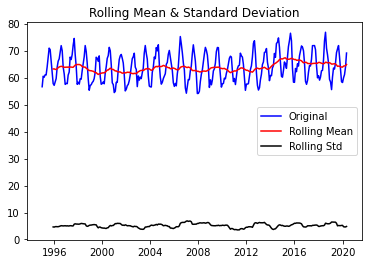

ADF Statistic: -2.183002688600185
p-value: 0.21247223383144193
Critical Values:
	1%: -3.453102162983312
	5%: -2.871558538275452
	10%: -2.5721082282996433


In [24]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(month_sd)

In [25]:
sd_df = city_temp.loc[city_temp['City'] == 'San Diego']
sd_df = sd_df.drop(['Region', 'Country', 'City'], axis = 1)
# sd_df['Date'] = pd.to_datetime(sd_df[['Year', 'Month', 'Day']].assign(day=1))
# sd_df = sd_df.drop(['Month', 'Day', 'Year'], axis = 1)


# week_sd = sd_df.groupby(['Region', 'Country', 'City']).resample('W-Wed', label='right', closed = 'right', on='Date').mean().reset_index().sort_values(by='Date')
# week_sd = week_sd.drop(['Region', 'Country', 'City'], axis = 1)
# week_sd.index = week_sd.Date
# week_sd = week_sd.drop('Date', axis=1)
# month = week_sd.index.month
# dummies = pd.get_dummies(month, prefix='month').iloc[:,:11]

sd_df['Datetime'] = pd.to_datetime(sd_df[['Year', 'Month']].assign(day=1))
sd_df.drop('Day', axis = 1)
sd_df.index = sd_df.Datetime
month_sd = sd_df.drop(['Datetime', 'Day'], axis =1)
month_sd = month_sd.groupby(['Year', 'Month']).mean().reset_index()
month_sd['Datetime'] = pd.to_datetime(month_sd[['Year', 'Month']].assign(day=1))
month_sd.index = month_sd.Datetime
month_sd = month_sd.drop(['Datetime', 'Year', 'Month'], axis =1 )
month_sd

,AvgTemperature
Datetime,
1995-01-01,56.596774
1995-02-01,60.482143
1995-03-01,60.093548
1995-04-01,60.993333
1995-05-01,60.954839
...,...
2020-01-01,58.158065
2020-02-01,59.958621
2020-03-01,61.077419


NameError: name 'week_sd' is not defined

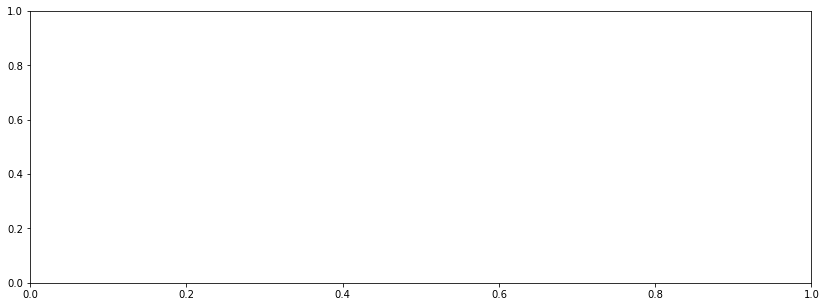

In [26]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).iloc[:, :11]
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    ax.plot(series.index, series)
    ax.plot(series.index, seasons_average_trend)
    
fig, ax = plt.subplots( figsize=(14, 5))

plot_seasonal_trend(ax, 'sd temps', week_sd)
plt.tight_layout()

In [ ]:
week_sd_seasonal_trend = fit_seasonal_trend(month_sd['AvgTemperature'])
week_sd_seasonal_detrended = week_sd['AvgTemperature'] - week_sd_seasonal_trend
week_sd_seasonal_detrended
autocorrelation_plot(week__sd_seasonal_detrended)

In [ ]:
model = ARIMA(week_sd, order=(1,1,1))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [27]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

week_stationary = difference(np.log(week_sd.values), 52)
result = adfuller(week_stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



NameError: name 'week_sd' is not defined

In [28]:
stepwise_fit = auto_arima(month_sd['AvgTemperature'], start_p = 1, start_q = 1, max_p = 5, max_q = 5, m = 12,
                          start_P = 0, seasonal = True, d = None, D=1, trace = True, error_action = 'ignore',
                          suppress_warning = True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1373.558, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1232.981, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1371.779, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1295.884, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1211.224, Time=0.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1303.429, Time=0.32 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1210.019, Time=0.42 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1233.117, Time=0.16 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1211.9

In [29]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  305
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood                -597.493
Date:                             Thu, 03 Dec 2020   AIC                           1206.985
Time:                                     13:12:44   BIC                           1229.067
Sample:                                          0   HQIC                          1215.829
                                             - 305                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2712      0.155     -1.746      0.081      -0.575       0.033
ar.L2          0.5055      0.079      6.384      0.000       0.350       0.661
ma.L1          0.7722      0.168      4.602      0.000       0.443       1.101
ar.S.L12      -0.6249      0.061    -10.204      0.000      -0.745      -0.505
ar.S.L24      -0.3028      0.059     -5.101      0.000      -0.419      -0.186
sigma2         3.3908      0.292     11.616      0.000       2.819       3.963
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.54
Prob(Q):                              0.92   Prob(JB):                         0.28
Heteroskedasticity (H):               1.20   Skew:                             0.22
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

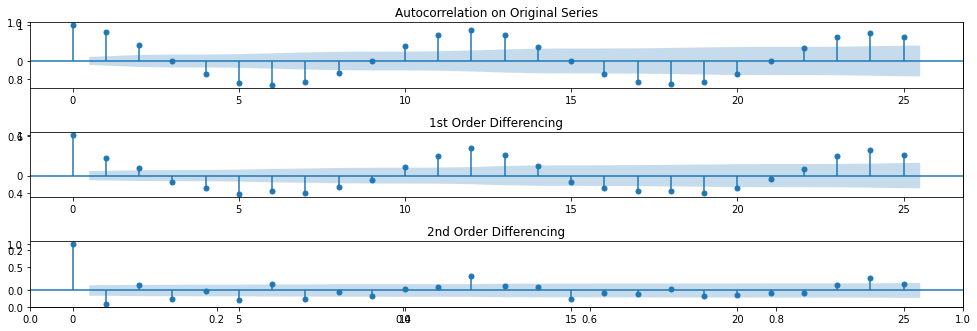

In [30]:
ax1 = fig.add_subplot(311)
fig2 = plot_acf(month_sd, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig2 = plot_acf(month_sd.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig2 = plot_acf(month_sd.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")
fig.tight_layout()
fig2

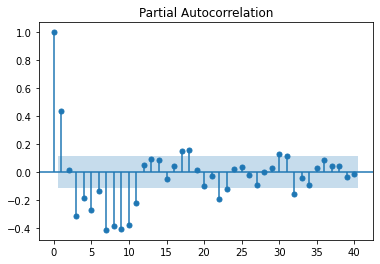

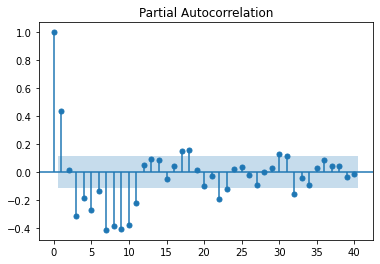

In [31]:
plot_pacf(month_sd.diff().dropna(), lags=40)

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

train = month_sd.iloc[:len(month_sd)-12]
test = month_sd.iloc[len(month_sd) - 12:]

model = SARIMAX(train,
                order = (2, 0 ,1),
                seasonal_order =(2, 1, 0, 12) )
result = model.fit()
result.summary()


,AvgTemperature
Datetime,
1995-01-01,56.596774
1995-02-01,60.482143
1995-03-01,60.093548
1995-04-01,60.993333
1995-05-01,60.954839
...,...
2019-01-01,58.396774
2019-02-01,55.528571
2019-03-01,60.122581


In [36]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

rmse(test, predictions)
mean_squared_error(test, predictions)

5.452423001494949

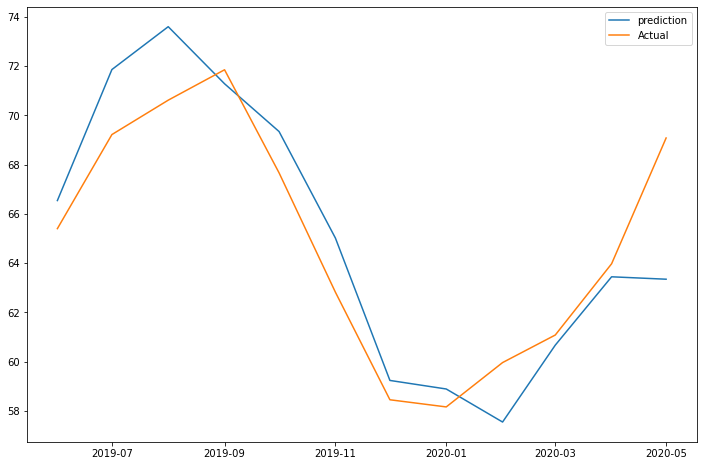

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))

start = len(train)
end = len(train) + len(test) - 1

predictions = result.predict(start, end, typ='levels').rename('Predictions')

ax.plot(predictions, label= 'prediction')
ax.plot(test, label='Actual')
ax.legend()

In [37]:
model = SARIMAX(month_sd,  
                        order = (2, 0, 1),  
                        seasonal_order =(2, 1, 0, 12)) 
result = model.fit()

forecast = result.predict(start = len(month_sd) - 12 ,
                          end = (len(month_sd) - 1) + 6,
                          typ = 'levels').rename('Forecast')

fig, ax = plt.subplots(figsize=(20, 4), dpi=1600)
ax.plot(month_sd, label = 'Avg Temp', color = 'b')
ax.plot(forecast, label ='Forecast', color ='y', linewidth=2)
ax.legend()

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = week_sd.values
size = int(len(X) * .66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions, color='red')



NameError: name 'week_sd' is not defined

In [13]:
ghg = replace_col_values(ghg, 'category', 'carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent', 'CO2 Emissions')
ghg = replace_col_values(ghg, 'category', 'methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent', 'Methane Emissions')
ghg = replace_col_values(ghg, 'category', 'hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent', 'Hydrofluorocarbons Emissions')
ghg = replace_col_values(ghg, 'category', 'nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent', 'Nitrous Oxide Emissions')
ghg = replace_col_values(ghg, 'category', 'sulphur_hexafluoride_sf6_emissions_in_kilotonne_co2_equivalent', 'Sulphur Hexafluoride Emissions')


In [14]:
ghg = ghg[ghg['category'].isin(['CO2 Emissions', 'Methane Emissions', 'Hydrofluorocarbons Emissions', 'Nitrous Oxide Emissions', 'Sulphur Hexafluoride Emissions'])]
ghg

,country_or_area,year,value,category,month
0,Australia,2014,393126.946994,CO2 Emissions,1
1,Australia,2014,393126.946994,CO2 Emissions,2
2,Australia,2014,393126.946994,CO2 Emissions,3
3,Australia,2014,393126.946994,CO2 Emissions,4
4,Australia,2014,393126.946994,CO2 Emissions,5
...,...,...,...,...,...
99967,United States of America,1990,31080.406159,Sulphur Hexafluoride Emissions,8
99968,United States of America,1990,31080.406159,Sulphur Hexafluoride Emissions,9
99969,United States of America,1990,31080.406159,Sulphur Hexafluoride Emissions,10
99970,United States of America,1990,31080.406159,Sulphur Hexafluoride Emissions,11


In [15]:
ghg.loc[ghg['category'] =='CO2 Emissions']
ghg.drop('month', axis = 1)
ghg = ghg.groupby(['country_or_area', 'year', 'category']).sum('value').reset_index()

In [16]:
total_emissions = {'type' :ghg['category'],
                   'value': ghg['value'],
                   'year': ghg['year']}

total_emissions_df = pd.DataFrame(total_emissions)
total_emissions_df


,type,value,year
0,CO2 Emissions,3.339191e+06,1990
1,Hydrofluorocarbons Emissions,1.709620e+04,1990
2,Methane Emissions,1.425226e+06,1990
3,Nitrous Oxide Emissions,1.841472e+05,1990
4,Sulphur Hexafluoride Emissions,2.532222e+03,1990
...,...,...,...
5224,CO2 Emissions,6.667208e+07,2014
5225,Hydrofluorocarbons Emissions,1.886848e+06,2014
5226,Methane Emissions,8.769944e+06,2014
5227,Nitrous Oxide Emissions,4.842017e+06,2014


In [17]:
total_emissions_df.groupby(['type', 'year']).sum('value').reset_index()
total_emissions_df.loc[total_emissions_df['year'] >= 1995]


,type,value,year
25,CO2 Emissions,3.661951e+06,1995
26,Hydrofluorocarbons Emissions,1.204839e+04,1995
27,Methane Emissions,1.318809e+06,1995
28,Nitrous Oxide Emissions,1.869384e+05,1995
29,Sulphur Hexafluoride Emissions,3.627696e+03,1995
...,...,...,...
5224,CO2 Emissions,6.667208e+07,2014
5225,Hydrofluorocarbons Emissions,1.886848e+06,2014
5226,Methane Emissions,8.769944e+06,2014
5227,Nitrous Oxide Emissions,4.842017e+06,2014


In [ ]:
ghg
ec_city_temp = city_temp.loc[(city_temp['Country'] == 'Equador')]
ec_city_temp = ec_city_temp.loc[ec_city_temp['Year'] < 2015]
guaya = ec_city_temp.loc[(city_temp['City'] == 'Guayaquil')]
quito = ec_city_temp.loc[(city_temp['City'] == 'Quito')]
#pd.date_range(start='1/1/1979', periods=len(ec_city_temp), freq='D')
guaya_df = ec_city_temp.drop(['Region', 'Country', 'City'], axis = 1)
guaya_df_months = guaya_df.drop('Day', axis = 1)
guaya_df_months = guaya_df_months.groupby(['Year', 'Month']).mean('AvgTemperature').reset_index()
guaya_df_months['Date'] = pd.date_range(start='1/1/1995', periods=len(guaya_df_months), freq='M')
guaya_df_months.index = guaya_df_months.Date
# ec_city_temp['Date'] = pd.date_range(start='1/1/1995', periods=len(ec_city_temp), freq='D')

guaya = guaya.drop(['Day', 'Region', 'Country'], axis = 1)
guaya = guaya.groupby(['Year', 'Month', ]).mean('AvgTemperature')
guaya.plot()
city_temp


In [ ]:
# def rolling_mean_count(dte, months_back, months, df):
#     hours_back_start = (months_back + months) * 730
#     hours_back_end = months_back * 730
#     date_back_start = dte - timedelta(hours=hours_back_start)
#     date_back_end = dte - timedelta(hours=hours_back_end)
#     df_ss = df.loc[date_back_start:date_back_end]
#     rolling_mean = df_ss['AvgTemperature'].mean()
#     return rolling_mean

In [ ]:
quito

In [ ]:

guaya_df_months = guaya_df_months.loc[guaya_df_months['AvgTemperature'] > 21]
guaya_df_months = guaya_df_months.loc[guaya_df_months['Year'] > 1994]


guaya_df_months

In [ ]:
train_start = '1995-01-31'
train_end = '2010-12-31'

validation_start = '2011-01-31'
validation_end = '2012-12-31'

holdout_start = '2013-01-31'
holdout_end = '2014-12-31'

df_train = guaya_df_months.loc[train_start:train_end, :].copy()
df_validate = guaya_df_months.loc[validation_start: validation_end, :].copy()
df_holdout = guaya_df_months.loc[holdout_start:holdout_end, :].copy()
df_train['AvgTemperature'].plot(figsize=(12,4))

In [ ]:
def is_summer(month):
    if (month == 6 or month == 7 or month == 8):
        return 1
    return 0

def is_spring(month):
    if (month == 3 or month == 4 or month == 5):
        return 1
    return 0

def is_fall(month):
    if (month == 9 or month == 10 or month == 11):
        return 1
    return 0

def is_winter(month):
    if (month == 12 or month == 1 or month == 2):
        return 1
    return 0

In [ ]:
df_train['Winter'] = df_train['Month'].apply(is_winter)
df_validate['Winter'] = df_validate['Month'].apply(is_winter)
df_holdout['Winter'] = df_holdout['Month'].apply(is_winter)

df_train['Spring'] = df_train['Month'].apply(is_spring)
df_validate['Spring'] = df_validate['Month'].apply(is_spring)
df_holdout['Spring'] = df_holdout['Month'].apply(is_spring)

df_train['Summer'] = df_train['Month'].apply(is_summer)
df_validate['Summer'] = df_validate['Month'].apply(is_summer)
df_holdout['Summer'] = df_holdout['Month'].apply(is_summer)

df_train['Fall'] = df_train['Month'].apply(is_fall)
df_validate['Fall'] = df_validate['Month'].apply(is_fall)
df_holdout['Fall'] = df_holdout['Month'].apply(is_fall)



In [ ]:
df_train['rolling'] = df_train['AvgTemperature'].rolling(6,center= True).mean()
df_validate['rolling'] = df_validate['AvgTemperature'].rolling(6,center= True).mean()
df_holdout['rolling'] = df_holdout['AvgTemperature'].rolling(6,center= True).mean()

df_holdout

In [4]:
df_Xytrain = df_train.loc['1995-04-30': '2010-10-31'].copy()
df_validateXy = df_validate.loc['2011-04-30': '2012-10-31'].copy()
df_hoXy = df_holdout.loc['2013-04-30': '2013-10-31'].copy()
df_X = df_Xytrain[['Year', 'Month', 'Summer', 'Spring', 'Winter', 'Fall', 'rolling']].copy()
y = df_Xytrain['AvgTemperature'].values

X = df_X.values

NameError: name 'df_train' is not defined

In [5]:
regressor = RandomForestRegressor()
regressor.fit(X,y)

NameError: name 'X' is not defined

In [6]:
df_X_validate = df_validateXy[['Year', 'Month', 'Summer', 'Spring', 'Winter', 'Fall', 'rolling']].copy()
X_validate = df_X_validate.values
y_validate = df_validateXy['AvgTemperature'].values

NameError: name 'df_validateXy' is not defined

In [7]:
y_hat_valid = regressor.predict(X_validate)
y_data_valid = np.hstack([y_hat_valid.reshape(-1, 1), y_validate.reshape(-1, 1)])

NameError: name 'X_validate' is not defined

In [8]:
df_y_validate = pd.DataFrame(index=df_X_validate.index, 
                             columns=['y_hat','y_validate'],
                             data = y_data_valid)

NameError: name 'df_X_validate' is not defined

In [9]:
ax = df_y_validate[['y_hat', 'y_validate']].plot(figsize=(12,4))

NameError: name 'df_y_validate' is not defined

In [10]:
#city_temp = city_temp.drop('Day', axis=1)
#city_temp = city_temp.groupby(['Country', 'City', 'Year', 'Month']).mean('AvgTemperature').reset_index()
city_temp.loc[(city_temp['Country'] == 'Uganda') & (city_temp['Year'] == 1995)]

,Region,Country,City,Month,Day,Year,AvgTemperature
234892,Africa,Uganda,Kampala,1,2,1995,75.1
234899,Africa,Uganda,Kampala,1,9,1995,69.7
234900,Africa,Uganda,Kampala,1,10,1995,74.6
234901,Africa,Uganda,Kampala,1,11,1995,73.3
234902,Africa,Uganda,Kampala,1,12,1995,73.8
...,...,...,...,...,...,...,...
235251,Africa,Uganda,Kampala,12,27,1995,73.2
235252,Africa,Uganda,Kampala,12,28,1995,72.7
235253,Africa,Uganda,Kampala,12,29,1995,70.7
235254,Africa,Uganda,Kampala,12,30,1995,73.1


In [11]:
city_temp = city_temp.loc[city_temp['Year'] >= 1995]
city_temp_years = city_temp.drop('Month', axis = 1).groupby(['Country', 'City', 'Year']).mean('AvgTemperature').reset_index()
city_temp_years = city_temp_years.loc[(city_temp_years['Year'] == 201) | (city_temp_years['Year'] == 1995)]
city_temp_years

,Country,City,Year,Day,AvgTemperature
24,Algeria,Algiers,1995,15.754821,64.410468
50,Argentina,Buenos Aires,1995,15.720548,61.701370
76,Australia,Brisbane,1995,15.720548,67.837808
102,Australia,Canberra,1995,15.720548,55.386849
128,Australia,Melbourne,1995,15.720548,63.295068
...,...,...,...,...,...
7840,Uzbekistan,Tashkent,1995,15.720548,59.083014
7866,Venezuela,Caracas,1995,15.720548,78.479726
7892,Vietnam,Hanoi,1995,15.720548,74.389041
7918,Yugoslavia,Belgrade,1995,15.720548,53.053973


In [12]:
city_temp_years_avg = city_temp_years.groupby(['Country', 'City', 'Year'])['AvgTemperature'].agg('max','min').diff().reset_index()
city_temp_years_avg

,Country,City,Year,AvgTemperature
0,Algeria,Algiers,1995,NaN
1,Argentina,Buenos Aires,1995,-2.709098
2,Australia,Brisbane,1995,6.136438
3,Australia,Canberra,1995,-12.450959
4,Australia,Melbourne,1995,7.908219
...,...,...,...,...
309,Uzbekistan,Tashkent,1995,-0.544932
310,Venezuela,Caracas,1995,19.396712
311,Vietnam,Hanoi,1995,-4.090685
312,Yugoslavia,Belgrade,1995,-21.335068


In [13]:
city_temp_2019 = city_temp_years_avg.loc[city_temp_years_avg['Year'] == 2014]
city_temp_2019 = city_temp_2019.loc[city_temp_2019['AvgTemperature'] > 0]
city_temp_2019 = city_temp_2019.loc[city_temp_2019['AvgTemperature'] < 10]
city_temp_2019.nlargest(5, 'AvgTemperature')
city_temp_2019

,Country,City,Year,AvgTemperature


In [14]:
df_X_ho = df_hoXy[['Year', 'Month', 'Summer', 'Spring', 'Winter', 'Fall', 'rolling']].copy()

X_holdout = df_X_ho.values

y_holdout = df_hoXy['AvgTemperature'].values

y_predict = regressor.predict(X_holdout)

y_compare = np.hstack([y_predict.reshape(-1,1), y_holdout.reshape(-1,1)])

df_y_compare = pd.DataFrame(index=df_X_ho.index, 
                           columns=['y_predict','y_holdout'],
                           data = y_compare)

ax = df_y_compare[['y_predict','y_holdout']].plot(figsize=(12,4))
ax.set_ylabel('Predicted count on holdout');

NameError: name 'df_hoXy' is not defined